In [61]:
import pandas as pd
import re
import pickle

In [50]:
# get today's over/under for each team from draftkings
df = pd.read_html("https://sportsbook.draftkings.com/leagues/basketball/nba")

# potential problem could occur if draft kings changes format of their html
df = df[0]

# rename column to today instead of tomorrow
# happens due to weird time zone issue when loading in data
df.rename(columns={"Tomorrow": "Today"}, inplace=True)

In [51]:
# function to separate date from team name
def split_team_name(team_and_date_long_string):
    """Splits up the messy "tomorrow" column from our scraped Draft Kings Data.
    Returns time, team abbreviation, and team name."""


    # find date - should be any characters ending with AM or PM
    # NOTE: game times appear to be 5 hours ahead of EST
    # not an issue unless we choose to implement this as a feature
    time = re.search(r'(.+)(AM|PM)', team_and_date_long_string)
    if not time:
        # if game is in progress, ignore
        return None, None, None
    
    time = time[0]
    # find team name - all characters after the date
    team = re.search(r'(.+)(AM|PM)(.+)', team_and_date_long_string)[3]

    # split abbreviation and team name
    team_abbrev = team.split(' ')[0]
    team_full = team.split(' ')[1]

    return time, team_abbrev, team_full

df[["time", "team_abbrev", "team_full"]] = df.apply(lambda x: split_team_name(x["Today"]), axis=1, result_type="expand")
df.dropna(inplace=True)

In [52]:
# convert team abbrev to 3 letters if its not

def expand_abbrev(abbrev, name):
    if name == "Lakers":
        return 'LAL'
    if name == "Knicks":
        return 'NYK'
    if name == "Clippers":
        return 'LAC'
    if name == "Spurs":
        return 'SAS'
    else:
        return abbrev

df["team_abbrev"] = df.apply(lambda x: expand_abbrev(x["team_abbrev"], x["team_full"]), axis=1)

In [53]:
team = df.team_abbrev.iloc[0]

In [54]:
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
celtics_id = celtics['id']

In [55]:
#this cell is ideal, but times out
from nba_api.stats.endpoints import leaguegamefinder

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]

# filter games df to only current nba season

games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22022,1610612738,BOS,Boston Celtics,0022200392,2022-12-10,BOS @ GSW,L,240,107,38,87,0.437,12,40,0.300,19,26,0.731,6,33,39,17,8,6,10,14,-16.0
1,22022,1610612738,BOS,Boston Celtics,0022200373,2022-12-07,BOS @ PHX,W,239,125,49,101,0.485,16,45,0.356,11,13,0.846,11,42,53,29,14,3,12,20,27.0
2,22022,1610612738,BOS,Boston Celtics,0022200355,2022-12-05,BOS @ TOR,W,240,116,44,90,0.489,13,36,0.361,15,21,0.714,13,36,49,27,6,3,11,22,6.0
3,22022,1610612738,BOS,Boston Celtics,0022200346,2022-12-04,BOS @ BKN,W,241,103,35,81,0.432,15,38,0.395,18,20,0.900,8,40,48,18,11,9,15,19,11.0
4,22022,1610612738,BOS,Boston Celtics,0022200328,2022-12-02,BOS vs. MIA,L,265,116,40,87,0.460,15,45,0.333,21,28,0.750,7,41,48,26,6,2,20,18,-4.0


In [56]:
# set max columns none
pd.set_option('display.max_columns', None)
games

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22022,1610612738,BOS,Boston Celtics,0022200392,2022-12-10,BOS @ GSW,L,240,107,38,87,0.437,12,40,0.300,19,26,0.731,6,33,39,17,8,6,10,14,-16.0
1,22022,1610612738,BOS,Boston Celtics,0022200373,2022-12-07,BOS @ PHX,W,239,125,49,101,0.485,16,45,0.356,11,13,0.846,11,42,53,29,14,3,12,20,27.0
2,22022,1610612738,BOS,Boston Celtics,0022200355,2022-12-05,BOS @ TOR,W,240,116,44,90,0.489,13,36,0.361,15,21,0.714,13,36,49,27,6,3,11,22,6.0
3,22022,1610612738,BOS,Boston Celtics,0022200346,2022-12-04,BOS @ BKN,W,241,103,35,81,0.432,15,38,0.395,18,20,0.900,8,40,48,18,11,9,15,19,11.0
4,22022,1610612738,BOS,Boston Celtics,0022200328,2022-12-02,BOS vs. MIA,L,265,116,40,87,0.460,15,45,0.333,21,28,0.750,7,41,48,26,6,2,20,18,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,21983,1610612738,BOS,Boston Celtics,0028300052,1983-11-05,BOS @ WAS,W,240,120,46,80,0.575,0,2,0.000,28,36,0.778,5,28,33,36,7,7,16,26,NaN
3722,21983,1610612738,BOS,Boston Celtics,0028300043,1983-11-04,BOS vs. IND,W,240,121,42,78,0.538,0,2,0.000,37,44,0.841,11,34,45,28,8,5,22,26,NaN
3723,21983,1610612738,BOS,Boston Celtics,0028300033,1983-11-02,BOS vs. MIL,W,240,119,44,78,0.564,0,0,NaN,31,38,0.816,14,24,38,26,7,7,18,18,NaN
3724,21983,1610612738,BOS,Boston Celtics,0028300019,1983-10-29,BOS @ CLE,W,240,108,44,88,0.500,0,3,0.000,20,29,0.690,13,31,44,25,12,7,13,22,NaN


In [57]:
games = df.copy()

In [59]:
team = df.team_abbrev.iloc[0]


# scrape from basketball reference
df = pd.read_html(f"https://www.basketball-reference.com/teams/{team}/2023_games.html")

df = df[0]

HTTPError: HTTP Error 404: Not Found

In [ ]:
df.dropna(subset={"Tm"}, inplace=True) # null scores haven't happened yet
df.drop(columns={"Unnamed: 3", "Unnamed: 4", "Unnamed: 8", "Notes"}, inplace=True) # drop columns we don't need
df = df[df["Date"] != "Date"] # remove header row showing up as a game


df.rename(columns={"Unnamed: 5": "Home", "Unnamed: 7": "Win"}, inplace=True)

In [ ]:
# function to convert Home column to 0 or 1
def home_to_binary(home):
    if home == "@":
        return 0
    else:
        return 1

# function to convert Win column to 0 or 1
def win_to_binary(win):
    if win == "W":
        return 1
    else:
        return 0

# function to return day of week (first 3 letters) from date
def get_day_of_week(date):
    return date[:3]

df["Home"] = df.apply(lambda x: home_to_binary(x["Home"]), axis=1)
df["Win"] = df.apply(lambda x: win_to_binary(x["Win"]), axis=1)
df["Day"] = df.apply(lambda x: get_day_of_week(x["Date"]), axis=1)

# set data types
df["Tm"] = df["Tm"].astype(int)
df["Opp"] = df["Opp"].astype(int)
df["W"] = df["W"].astype(int)
df["L"] = df["L"].astype(int)

In [ ]:
# function to determine what time of day a game is
def get_time_of_day(time):
    if time in(["10:00a", "10:30a", "11:00a", "11:30a"]):
        return "Morning"
    if time in(["12:00p", "12:30p", "1:00p", "1:30p", "2:00p", "2:30p", "3:00p", "3:30p"]):
        return "Afternoon"
    if time in(["4:00p", "4:30p", "5:00p", "5:30p", "6:00p", "6:30p", "7:00p", "7:30p"]):
        return "Evening"
    if time in(["8:00p", "8:30p", "9:00p", "9:30p", "10:00p", "10:30p", "11:00p", "11:30p"]):
        return "Night"
    else:
        return "Unknown"

df["dow"] = df.apply(lambda x: get_time_of_day(x["Start (ET)"]), axis=1)


# convert day column to numeric
def day_to_numeric(day):
    if day == "Mon":
        return 1
    if day == "Tue":
        return 2
    if day == "Wed":
        return 3
    if day == "Thu":
        return 4
    if day == "Fri":
        return 5
    if day == "Sat":
        return 6
    if day == "Sun":
        return 7

df["Day"] = df.apply(lambda x: day_to_numeric(x["Day"]), axis=1)

/tmp/ipykernel_4311/4219075429.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


<AxesSubplot: >

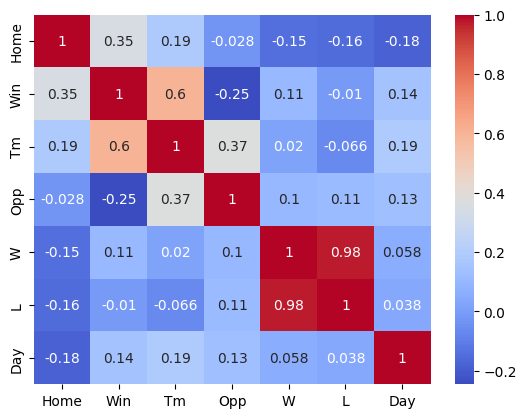

In [ ]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [ ]:
# ohe for dow
df = pd.get_dummies(df, columns=["dow"], drop_first=True)

In [ ]:
df

,Today,Spread,Total,Moneyline,time,team_abbrev,team_full
0,12:10AMBKN Nets,-6−110,O 227.5−110,−215,12:10AM,BKN,Nets
1,12:10AMWAS Wizards,+6−110,U 227.5−110,+185,12:10AM,WAS,Wizards
2,12:10AMMIA Heat,-3−110,O 228.5−110,−155,12:10AM,MIA,Heat
3,12:10AMIND Pacers,+3−110,U 228.5−110,+135,12:10AM,IND,Pacers
4,1:10AMATL Hawks,+9.5−110,O 226−110,+340,1:10AM,ATL,Hawks
5,1:10AMMEM Grizzlies,-9.5−110,U 226−110,−425,1:10AM,MEM,Grizzlies
6,1:40AMOKC Thunder,+8.5−115,O 228.5−110,+285,1:40AM,OKC,Thunder
7,1:40AMDAL Mavericks,-8.5−105,U 228.5−110,−345,1:40AM,DAL,Mavericks
8,1:40AMCLE Cavaliers,-8.5−115,O 220.5−110,−365,1:40AM,CLE,Cavaliers
9,1:40AMSA Spurs,+8.5−105,U 220.5−110,+300,1:40AM,SAS,Spurs


In [ ]:
# build basic linear regression to predict total points in a game
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[["Home", "Day", "W", "L"]]
y = df["Tm"] + df["Opp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_test, y_test)


-0.4527640906319641

In [ ]:
# create random forest regression model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

-0.3983556039850551

In [ ]:
# pickle export random forest model

pickle.dump(rf, open("rf_model.pkl", "wb"))

In [ ]:
y_preds = rf.predict(X_test)